In [114]:
import cv2
import numpy as np
from skimage import transform
from IPython.display import display
from skimage import transform, exposure
from PIL import Image, ImageOps,ImageEnhance
import thinplate.hybrid as tps
import blend_modes
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import blend_modes
pil_imshow = lambda x: display(Image.fromarray(x.astype(np.uint8)))

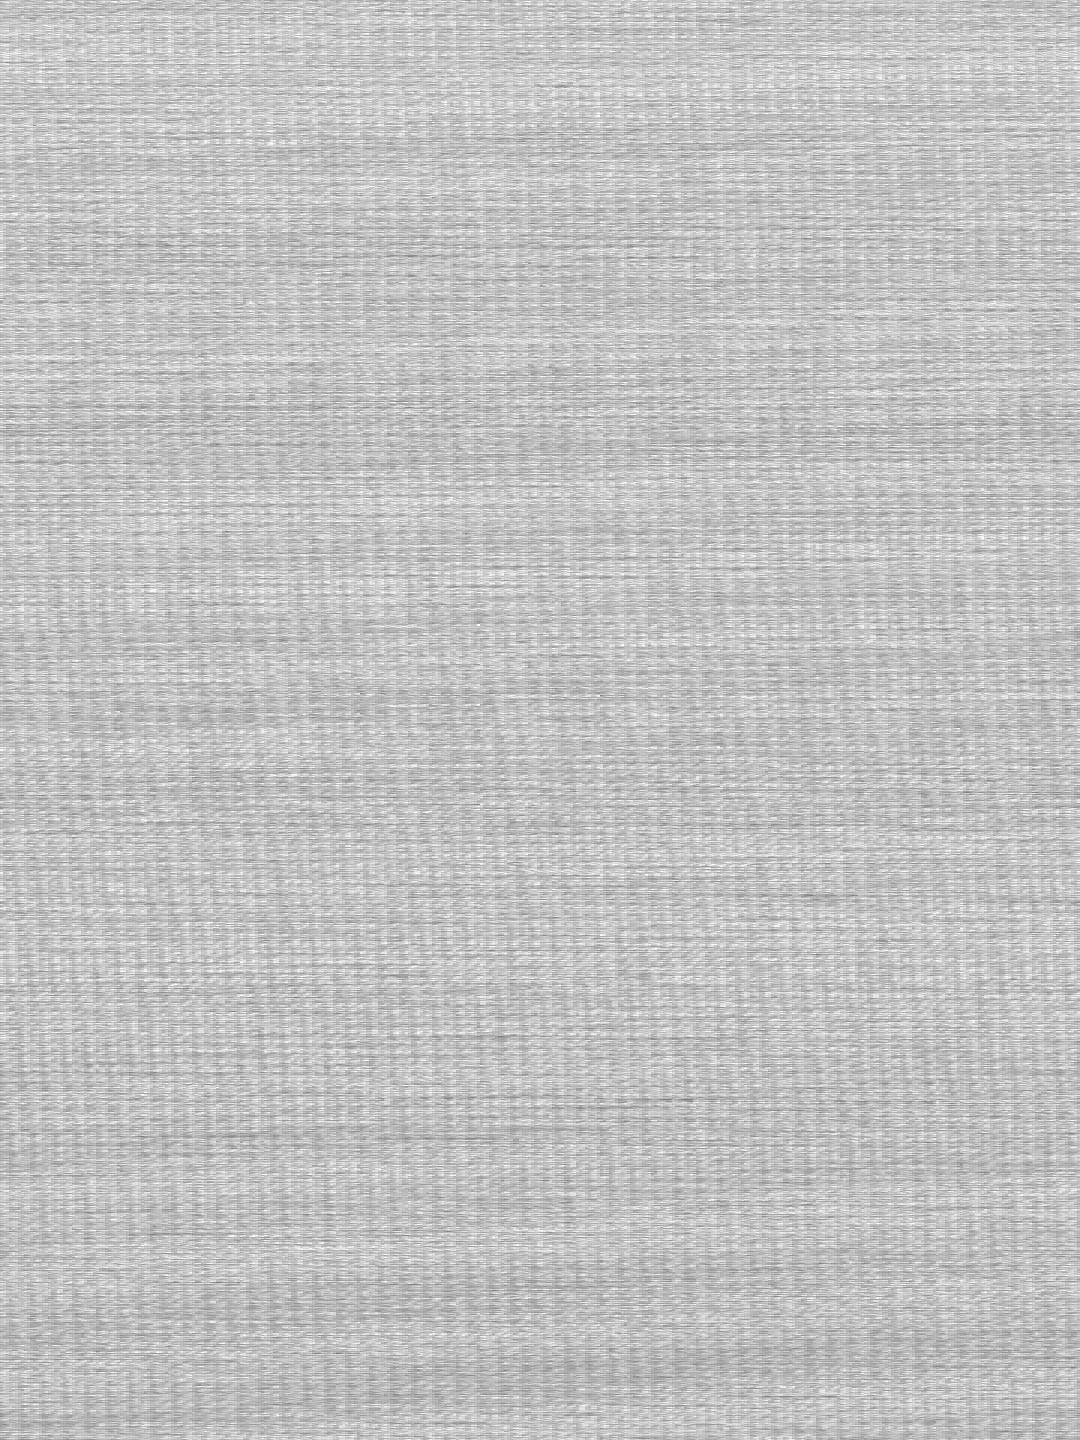

(1440, 1080, 3)


In [108]:
fabric = cv2.imread('dataset/fabric2.jpg')
fabric.resize((1440, 1080))
fabric_img = cv2.cvtColor(fabric, cv2.COLOR_BGR2RGB)
pil_imshow(fabric_img)
print(fabric_img.shape)

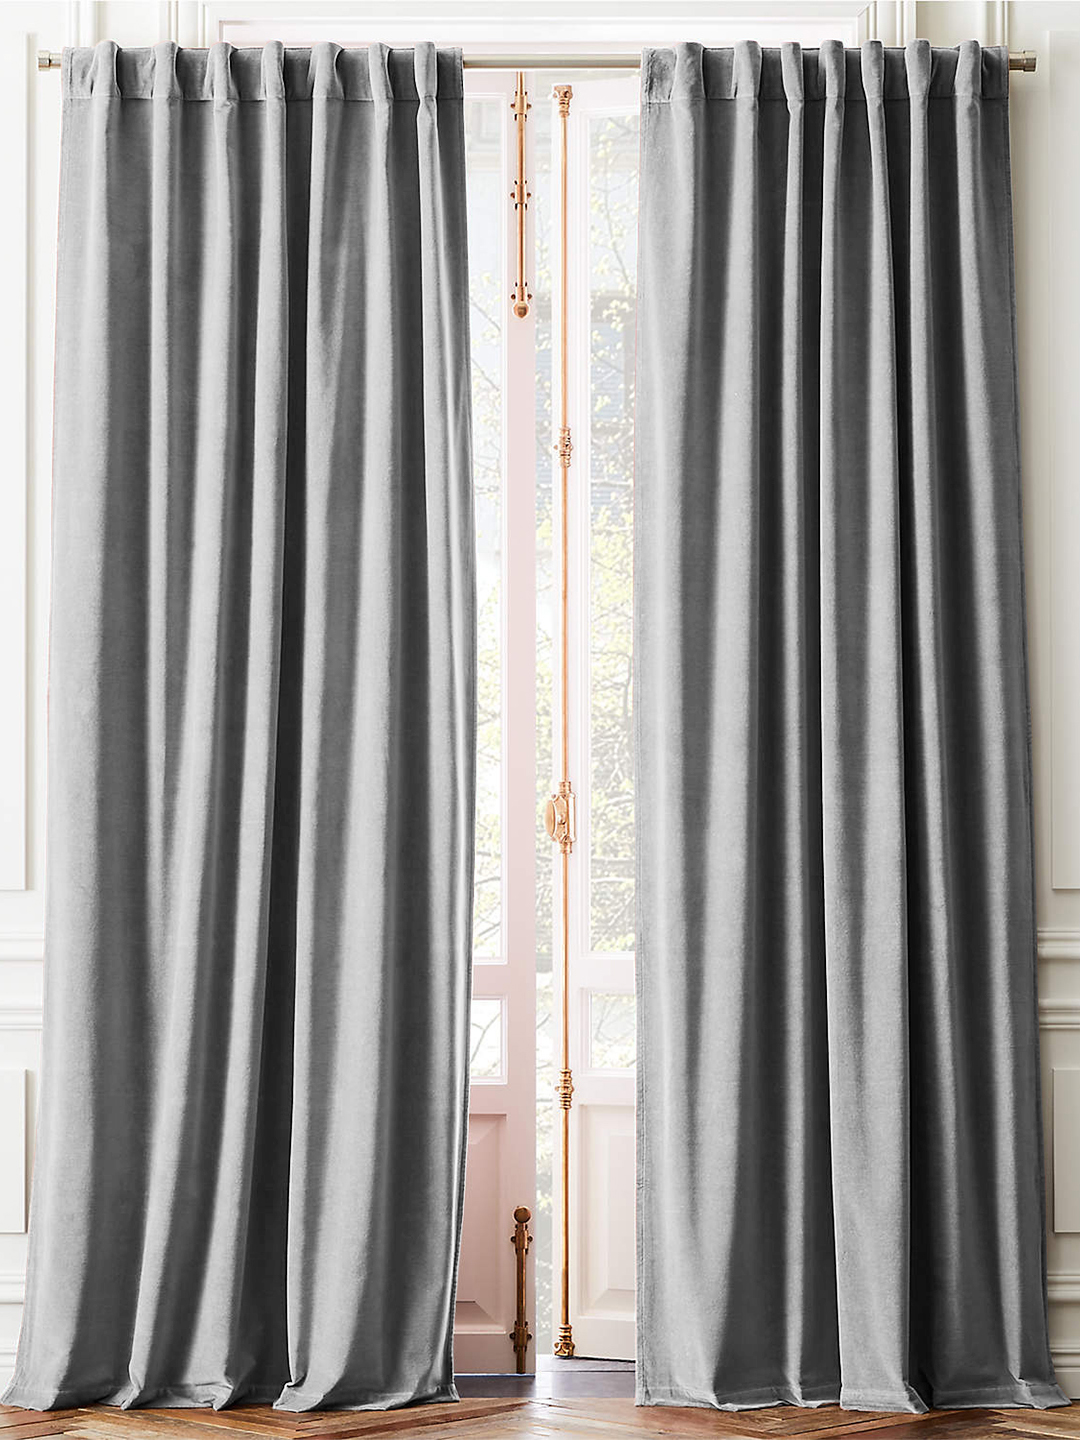

(1440, 1080, 3)


In [109]:
base = cv2.imread('dataset/base1.jpg')
base_img = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
pil_imshow(base_img)
print(base_img.shape)

In [115]:
def create_pts_for_tps(cords,res):
    # Ignore (Used in Bedsheets)
    slcs = {40:(0,None)}
    snew, dnew = [], []
    
    for idx,i in enumerate(cords):
        if len(i) > 2:
            s,e = slcs[idx] if idx in slcs else (0,None)
            snew.append(np.linspace(i[0], i[1], i[2])[s:e]) # generates new pts between the 2 end points
            dnew.append(np.linspace(i[3], i[4], i[2])[s:e])
        else:
            snew.append(np.array([i[0]]))
            dnew.append(np.array([i[1]]))

    # Src = fabric , dst = base Img
    c_src = np.vstack(snew).astype(np.float32)
    c_dst = np.vstack(dnew).astype(np.float32)
    # Check to see if they are same num of pts in src and dst
    assert len(c_src) == len(c_dst), f"{len(c_src)}, {len(c_dst)}"

    _, idxs = np.unique(c_dst.astype(int), return_index=True, axis=0)
    c_src = c_src[idxs]/1.
    c_dst = c_dst[idxs]/np.array(res).astype(np.float32) # divide by template size to make btw 0 1

    return c_src,c_dst


def Thin_plate_splines(c_src,c_dst,output_size, fabric):
    '''
    Function to generated grid based on thin plate splines.
    Saves grid and generates fabric segment for blending
    '''
    
    # We first calculate theta for our grid generation
    theta = tps.tps_theta_from_points(c_src, c_dst, reduced=False)
    # Genertaes grid x,y, values  where to map
    grid = tps.tps_grid(theta, c_dst, out_size)     # slowest step
    # Extract x and y values from grid to map it to org img
    mapx, mapy = tps.tps_grid_to_remap(grid, fabric.shape)

    # We create the fabric 
    tpw = cv2.remap(fabric, mapx, mapy, cv2.INTER_CUBIC)
    cv2.imwrite('fabric_after_tps.jpg', tpw)  # Change Segment Mask Name 
    print("Generated Fabric Segment Image")
    print()
    pil_imshow(tpw)
    return cv2.cvtColor(tpw, cv2.COLOR_BGR2RGB)

C_src : 12
C_dst : 12
Max should be 1 : 1.0
Max should be 1 : 0.98055553
__________________

Generated Fabric Segment Image



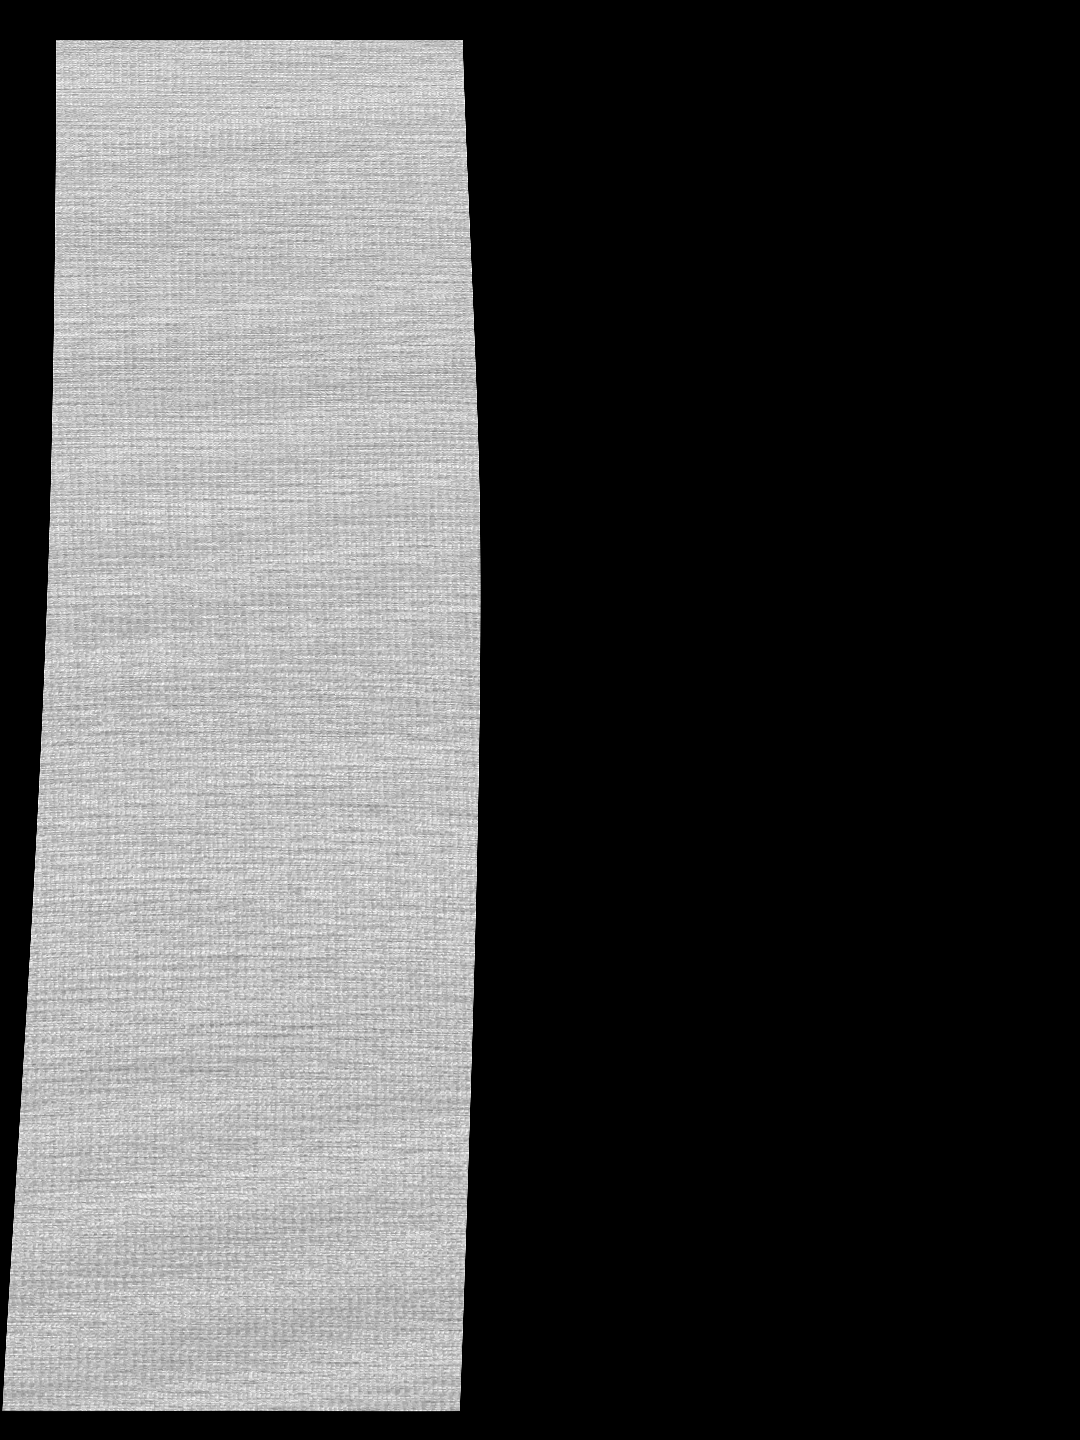

(1440, 1080, 3)


In [116]:
# Cords paste mask to our template (Fabric to template cords)

# Cordinates stucture : [[Top Left of Fabric], [Top Right of Fabric], 
#(Number of Points to be Generated between these endpoints), [Top Left of Base Img], [Top Right of Base Img]]

cords =[[[0.0, 0.0], [1.0, 0.0], 4, [56, 40], [463, 40]],     # (Fabric Dims, Template Dims)
        [[0.0, 0.4], [1.0, 0.4], 4, [50, 500], [480,500]],    
        [[0.0, 1.0], [1.0, 1.0], 4, [2, 1412], [460,1412]],]

# Parameters to adjust 
out_size = (1440,1080,3) # Size of Template IMG
res = [1080., 1440.] # w*h

# Extract Source and Destination points
c_src ,c_dst = create_pts_for_tps(cords,res)
# Generated Grid and Segment
left_mask = Thin_plate_splines(c_src,c_dst,out_size, fabric_img)
print(left_mask.shape)
# Saves Grid File (Important)
# np.save(grid_name, grid)  # Change Mask name 

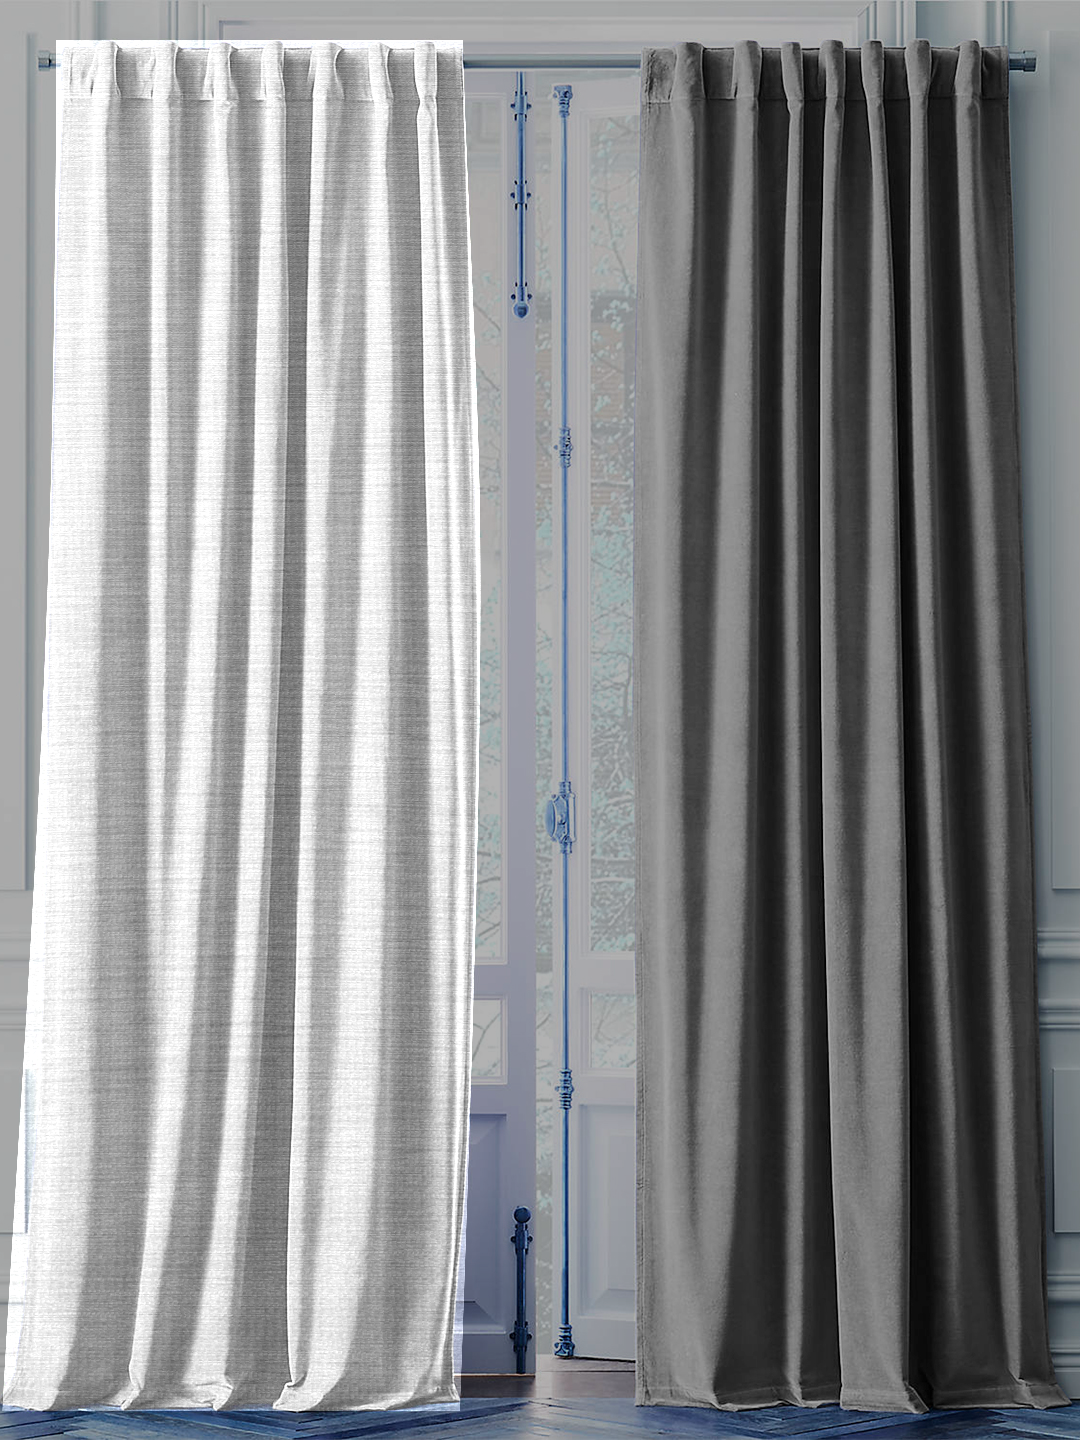

In [112]:
# left_mask_path = '/gdrive/MyDrive/spyne/Curtain-1/left mask.png'   # add your mask's path here

# mask1 = Image.open(left_mask_path) 
# base = Image.open('dataset/base1.jpg') 
# im2, mask1 = paste_text(left_mask_path, 'fabric_after_tps.jpg', (0, 0))   # send generated segment img for pasting
# base.paste(base, (0, 0), left_mask)

# back_im.save('bg.png') # saves the generated ouput for later use

# dst = cv2.addWeighted(np.array(im2), 0.5, np.array(back_im), 0.7, 0)
# print("Segment Generated Pasted on BASE_IMG")
# blended = cv2.addWeighted(left_mask, 0.7,base, 0.5, 0)
base_left = cv2.addWeighted(base, 0.7,left_mask, 0.5, 0)

# cv2.cvtColor(fabric, cv2.COLOR_BGR2RGB)
pil_imshow(base_left)

C_src : 16
C_dst : 16
Max should be 1 : 1.0
Max should be 1 : 0.99351853
__________________

Generated Fabric Segment Image



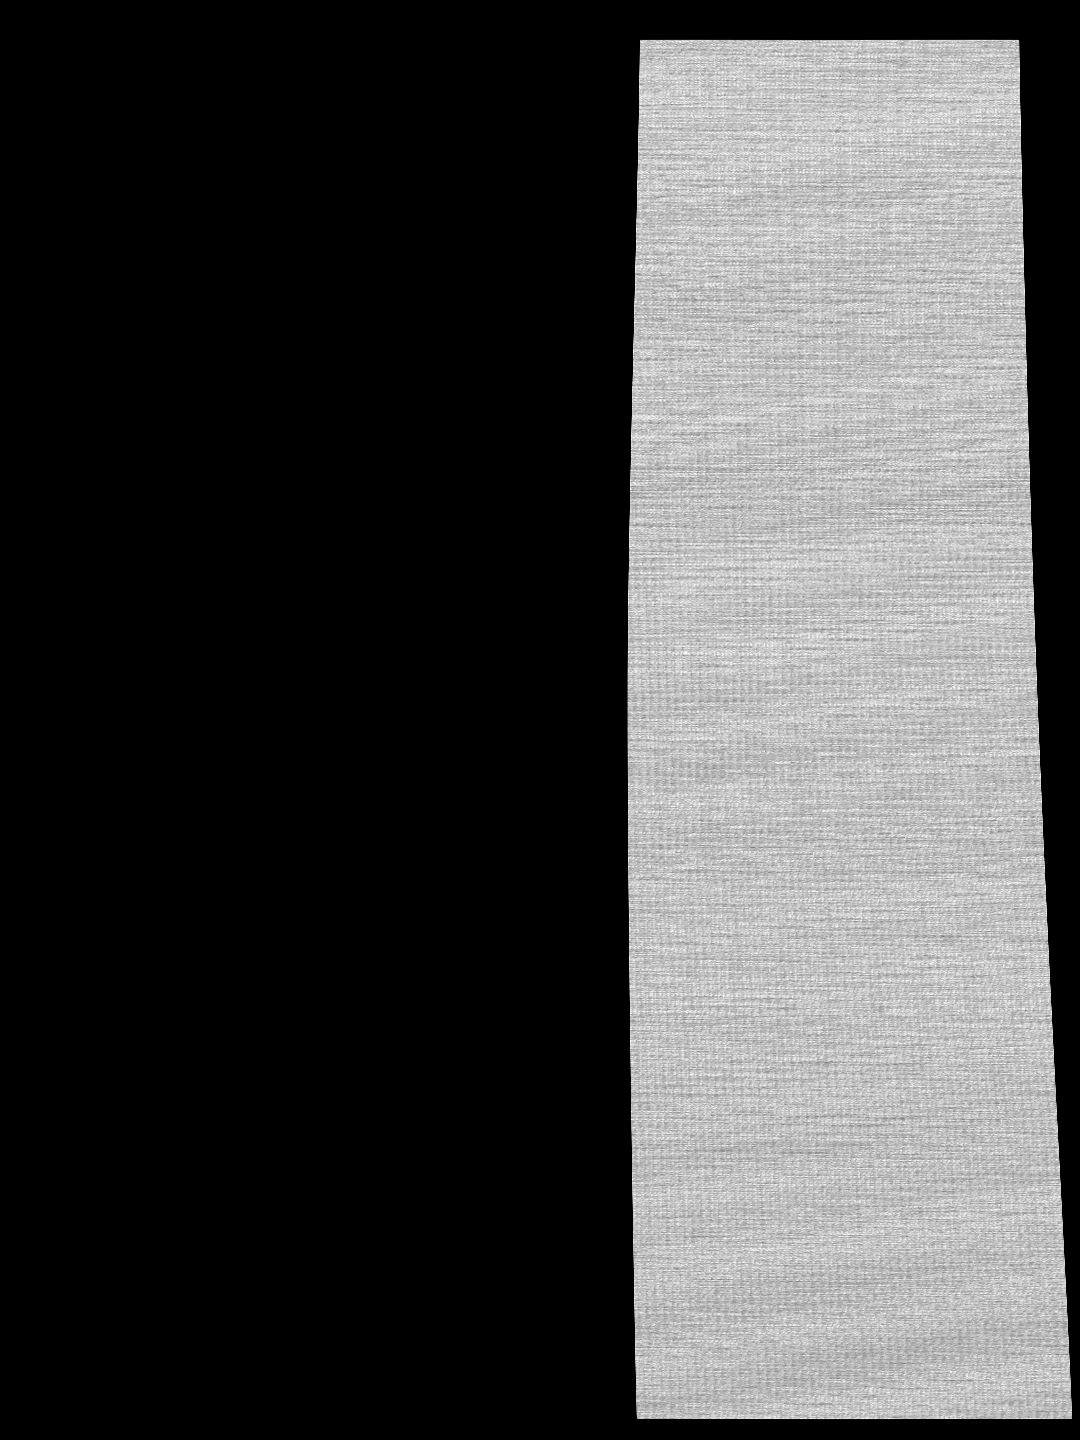

In [105]:
#  Cords paste mask to our template (Fabric to template cords)

# Cordinates stucture : [[Top Left of Fabric], [Top Right of Fabric], (Number of Points to be Generated between these endpoints), [Top Left of Base Img], [Top Right of Base Img]]

cords =[[[0.0, 0.0], [1.0, 0.0], 4, [640, 40], [1020, 40]],     # (Fabric Dims, Template Dims)
        [[0.0, 0.2], [1.0, 0.2], 4, [635, 289], [1200,289]],
        [[0.0, 0.4], [1.0, 0.4], 8, [628, 639], [1036,639]],    
        [[0.0, 1.0], [1.0, 1.0], 4, [637, 1420], [1073,1420]],         
    ]



# Parameters to adjust 
out_size = (1440,1080,3) # Size of Template IMG
res = [1080., 1440.] # w*h
# grid_name = 'right_mask.npy'

# Extract Source and Destination points
c_src ,c_dst = create_pts_for_tps(cords,res)
# Generated Grid and Segment
right_mask = Thin_plate_splines(c_src,c_dst,out_size)
# Saves Grid File (Important)
# np.save(grid_name, grid)  # Change Mask name 

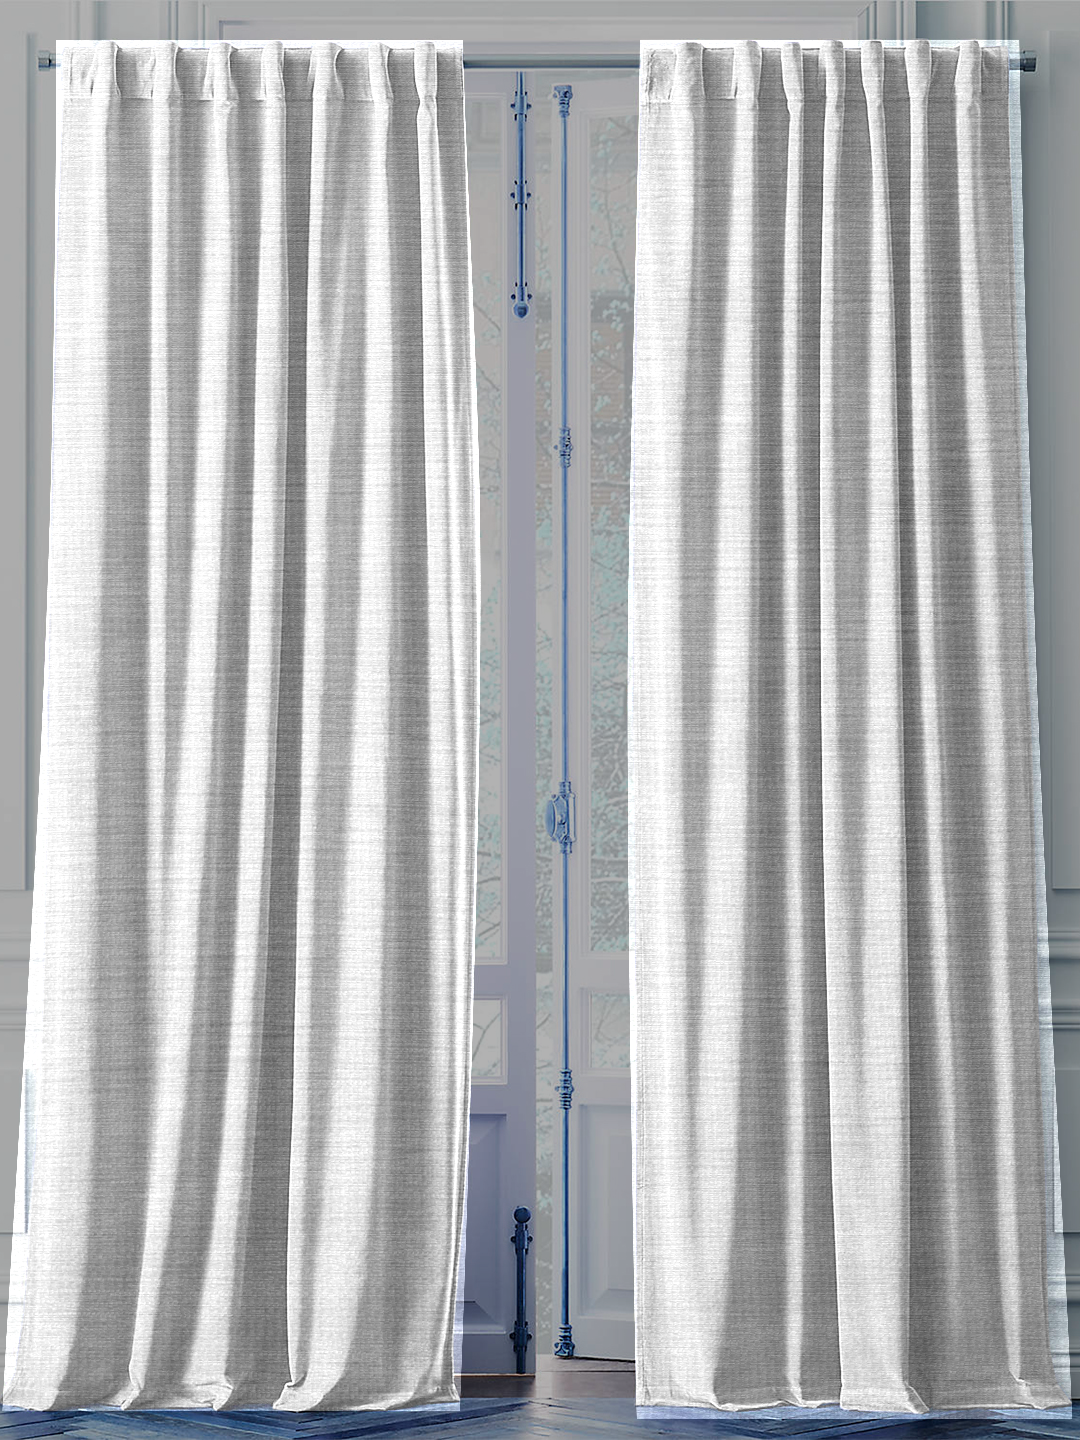

(1440, 1080, 3)

In [106]:
back_im = cv2.addWeighted(base_left, 1,right_mask, 0.5, 0)
pil_imshow(back_im)
back_im.shape